In [1]:
import dgl
import dgl.function as fn
import torch
from dgl.nn import GraphConv
import torch.nn as nn
import torch.nn.functional as F
from dgl.data import BACommunityDataset

In [37]:
class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, hidden_feats=20):
        '''
        in_feats: Input features
        out_feats: Output features
        hidden_feats: Hidden layer features
        '''
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_feats)
        self.conv2 = GraphConv(hidden_feats, hidden_feats)
        self.conv3 = GraphConv(hidden_feats, out_feats)
#         self.conv4 = GraphConv(hidden_feats, out_feats)
        
    def forward(self, graph, feat, eweight=None):
        with graph.local_scope():
            feat = self.conv1(graph, feat)
            feat = F.relu(feat)
            feat = self.conv2(graph, feat)
            feat = F.relu(feat)
            feat = self.conv3(graph, feat)
#             feat = F.relu(feat)
#             feat = self.conv4(graph, feat)
            graph.ndata['h'] = feat
            if eweight is None:
                graph.update_all(fn.copy_u('h', 'm'), fn.sum('m', 'h'))
            else:
                graph.edata['w'] = eweight
                graph.update_all(fn.u_mul_e('h', 'w', 'm'), fn.sum('m', 'h'))
            return graph.ndata['h']

In [32]:
def train(model, g, epochs=10, printInterval=5, lr=0.001):
    '''
    model: Training Model
    g: Training graph
    epochs: Number of epochs
    printInterval: Interval that data is displayed at
    lr: Learning rate
    '''
    optimizer = torch.optim.Adam(model.parameters(), lr)

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    test_mask = g.ndata['test_mask']
    
    for epoch in range(epochs):
        model.train()
        logits = model(g, features)
        pred = logits.argmax(1)
        
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % printInterval == 0:
            print('In epoch {}, loss: {:.3f}, train acc: {:.3f}, test acc: {:.3f})'.format(
                epoch, loss, train_acc, test_acc))
        
    print('In epoch {}, loss: {:.3f}, train acc: {:.3f}, test acc: {:.3f})'.format(
            epoch, loss, train_acc, test_acc))

In [56]:
from dgl.nn import GNNExplainer
import networkx as nx


def displaySG(model, nodeID):
    # Defines explainer model and trains model to explain node
    features = g.ndata['feat']
    explainer = GNNExplainer(model, num_hops=2, lr=0.001, num_epochs=150)
    new_center, sg, feat_mask, edge_mask = explainer.explain_node(nodeID, g, features)
    
    # Draws sub-graph
    nx_G = sg.to_networkx().to_undirected()
    # Create Node Color Map
    colors = ['azure', 'tan', 'wheat', 'lavender', 'lightskyblue', 'lightsalmon', 'lightgreen', 'thistle', 
              'slateblue', 'roseybrown', 'plum', 'peru', 'pink', 'palegreen', 'olive', 'moccasin', 'mintcream',
              'oldlace', 'linen', 'maroon', 'green', 'yellow', 'blue', 'orange', 'lightyellow', 'lightpink',
              'lavenderblush', 'ivory', 'purple', 'violet', 'lightgray', 'darkgreen', 'darkyellow', 'darkblue',
              'honeydue', 'darkpurple', 'darkorange', 'coral', 'hotpink', 'gainsboro']
    color_map = []
    for i, node in enumerate(nx_G):
        if node == new_center.numpy()[0]:
            color_map.append('gray')
        else:
            color_map.append(colors[sg.ndata['label'].numpy()[i]])
        
    # Draw Graph
    pos = nx.kamada_kawai_layout(nx_G)
    nx.draw_networkx(nx_G, pos, node_color=color_map, with_labels=True)
#     print(colors[sg.ndata['label'].numpy()[new_center.numpy()[0]]])
    
    return feat_mask, edge_mask

In [33]:
data = BACommunityDataset()
g = data[0]
g = dgl.add_self_loop(g)

Done loading data from cached files.


In [38]:
# Create train and test masks
n_nodes = g.num_nodes()

train_mask = torch.zeros((n_nodes), dtype=bool)
test_mask = torch.zeros((n_nodes), dtype=bool)

n_train = int(n_nodes * 0.8)

train_mask[:n_train] = True
test_mask[n_train:] = True

g.ndata['train_mask'] = train_mask
g.ndata['test_mask'] = test_mask
g.ndata['feat'] = torch.randn((n_nodes, 10)) 

In [53]:
# features = g.ndata['feat']
# model = GCN(features.shape[1], data.num_classes)
# train(model, g, epochs=1000, printInterval=50, lr=.2)
# torch.save(model, './models/BACommunity_Trained_Model.pt')
model = torch.load('./models/BACommunity_Trained_Model.pt')

Explain node {node_id}: 100%|████████████████| 150/150 [00:00<00:00, 367.70it/s]


(tensor([0.5428, 0.5730, 0.5041, 0.5506, 0.5161, 0.4799, 0.4772, 0.5271, 0.4818,
         0.5045]),
 tensor([0.3282, 0.6010, 0.7989, 0.5626, 0.5752, 0.7293, 0.8081, 0.4148]))

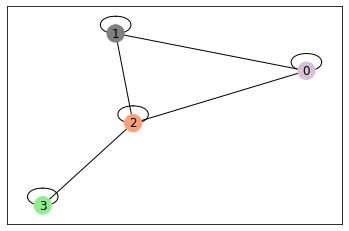

In [62]:
displaySG(model, 56)

In [85]:
uniqDict = {}
labels = g.ndata['label'].numpy()

for i in range(len(labels)):
    if not labels[i] in uniqDict:
        uniqDict[labels[i]] = [i]
    else:
        uniqDict[labels[i]].append(i)

In [86]:
uniqDict # Dictionary for node index of each class

{6: [0,
  1,
  2,
  3,
  4,
  5,
  6,
  9,
  11,
  12,
  13,
  14,
  20,
  24,
  27,
  28,
  32,
  37,
  47,
  48,
  50,
  53,
  54,
  59,
  63,
  64,
  67,
  75,
  78,
  80,
  81,
  82,
  85,
  87,
  94,
  97,
  101,
  105,
  110,
  111,
  112,
  114,
  115,
  120,
  123,
  131,
  137,
  139,
  144,
  145,
  146,
  150,
  151,
  159,
  175,
  183,
  184,
  189,
  194,
  195,
  196,
  199,
  201,
  202,
  204,
  206,
  207,
  224,
  226,
  228,
  233,
  235,
  238,
  242,
  244,
  248,
  254,
  256,
  258,
  268,
  274,
  283,
  286,
  288,
  293,
  307,
  312,
  323,
  345,
  350,
  394,
  401,
  407,
  411,
  422,
  435,
  444,
  464,
  465,
  512,
  518,
  522,
  525,
  530,
  531,
  533,
  542,
  546,
  582,
  584,
  607,
  611,
  614,
  616,
  637,
  640,
  646,
  650,
  652,
  676,
  688,
  693,
  700,
  705,
  706,
  707,
  712,
  717,
  719,
  756,
  766,
  769,
  773,
  774,
  786,
  850,
  890,
  893,
  894,
  903,
  914,
  934,
  945,
  946,
  981,
  989,
  992,
  1005,
  10

Explain node {node_id}: 100%|████████████████| 150/150 [00:00<00:00, 358.30it/s]


(tensor([0.5186, 0.4650, 0.4849, 0.5187, 0.5063, 0.5081, 0.5286, 0.4734, 0.5484,
         0.5245]),
 tensor([0.5255, 0.4525, 0.7103, 0.6189, 0.3475, 0.3987, 0.7518, 0.6181, 0.4286,
         0.1593, 0.6008, 0.4381]))

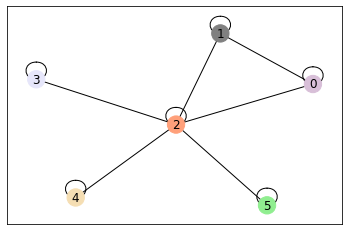

In [96]:
displaySG(model, 42) # Each classes sg should look the same if the explainer works properly